All credit goes to Vizuara from where I am learnign this by below youtube playlist.

https://www.youtube.com/playlist?list=PLPTV0NXA_ZSgsLAr8YCgCwhPIJNNtexWu


## IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT

GPT-2 Small model

In [ ]:
# GPT config 124M
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary Size
    "context_length": 1024, # Context Length
    "emd_dim": 768,         # Embedding Dimention
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layer
    "drop_rate": 0.1,       # Droput rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
%pip install tiktoken -q

## GPT Architecture Part 1 : Dummy GPT model class

- **Step 1:** Use a placeholder for Transformer Block
- **Step 2:** Use Placeholder for Layer Norm

In [ ]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emd_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emd_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    # Use a placeholder for TransformerBlock
    self.transformer_block = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
          )
     # Use a placeholder for LayerNorm
    self.layer_norm = DummyLayerNorm(cfg["emd_dim"])

    self.out_head = nn.Linear(cfg["emd_dim"], cfg["vocab_size"],bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.transformer_block(x)
    x = self.layer_norm(x)
    logits = self.out_head(x)
    return logits


class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    # A simple placeholder

  def forward(self, x):
    # This block does nothing and just returns its input.
    return x


class DummyLayerNorm(nn.Module):
  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()
    # The parameters here are just to mimic the LayerNorm interface.

  def forward(self, x):
    # This layer does nothing and just returns its input.
    return x




##### Lets test this dummy GPT 😀

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Logit Shape", logits.shape)
print(logits)

Logit Shape torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## GPT Architecture Part 2 : Layer Normalization


In [ ]:
# Start with a simple example for Normalization
torch.manual_seed(123)
batch_exmaple = torch.randn(2,5) #A
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_exmaple)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [ ]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean : \n", mean)
print("var : \n", var)

Mean : 
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
var : 
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalization layer output: \n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean : \n", mean)
print("var : \n", var)

Normalization layer output: 
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean : 
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
var : 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
torch.set_printoptions(sci_mode=False)
print("Mean : \n", mean)
print("var : \n", var)

Mean : 
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
var : 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5 # to prevent division by zero
    self.scale = nn.Parameter(torch.ones(emb_dim))  # Trainable Parameter
    self.shift = nn.Parameter(torch.zeros(emb_dim)) # Trainable Parameter

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    # print("mean shape : ", mean.shape)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    # print("var shape : ", var.shape)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    # print("norm_x shape : ", norm_x.shape)
    # print("scale shape : ", self.scale.shape)
    # print("shift shape : ", self.shift.shape)
    return self.scale * norm_x + self.shift


In [ ]:
print(batch_exmaple)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])


In [ ]:

layer = LayerNorm(emb_dim=5)
out_ln = layer(batch_exmaple)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("Mean : \n", mean)
print("var : \n", var)


Mean : 
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
var : 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## GPT Architecture Part 3 : Feed Forward Neural Network with Gelu Activiation

In [ ]:
# Approximate GELU implementaiton
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (
        1+torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) *
             (x + 0.044715 * torch.pow(x, 3))
        )
    )



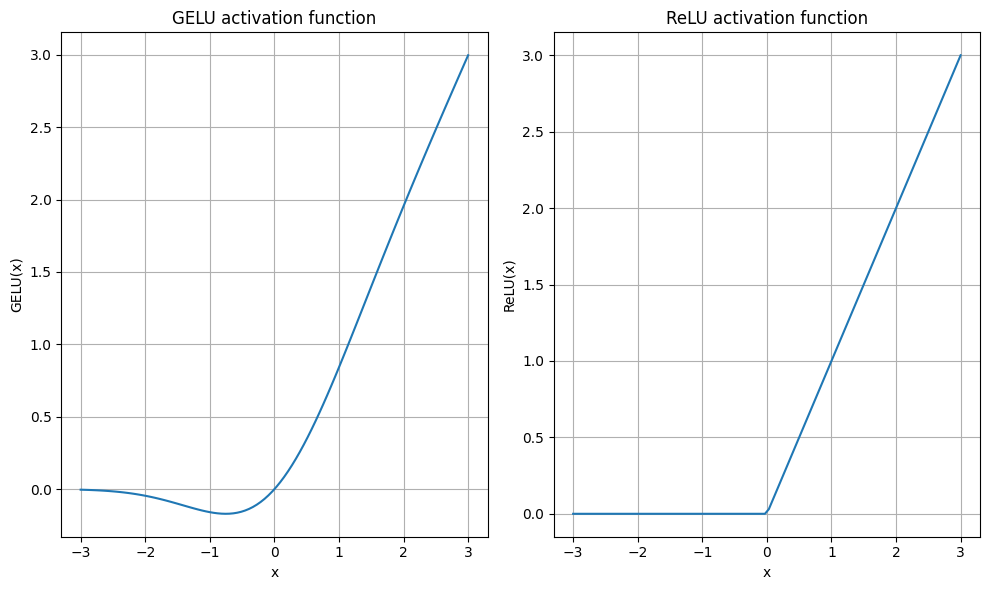

In [ ]:
# Plot and compare with Relu
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

# Sample Data
x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(10,6))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
# Implement Feed Forward Network
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emd_dim"], 4*cfg["emd_dim"]), # Exapansion
        GELU(), # Activitation
        nn.Linear(4*cfg["emd_dim"], cfg["emd_dim"]) # Contraction
    )

  def forward(self, x):
    return self.layers(x)


In [ ]:
# Utilize Feed Forward Network Example
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## GPT Architecture Part 4: Shortcut Connections

In [ ]:
class ExampleDeepNueralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
    ])


  def forward(self, x):
    for i, layer in enumerate(self.layers):
      # Compute the output of the current layer
      layer_output = layer(x)
      # Chekc if shorcut connection can be applied
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x


In [ ]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNueralNetwork(layer_sizes, use_shortcut=False)
# model_with_shortcut = ExampleDeepNueralNetwork(layer_sizes, use_shortcut=True)

In [ ]:
# Function ot preint the gradient at each layer
def print_gradients(model, x):
  output = model(x)
  loss = output.sum()
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output, target)
  loss.backward()

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"Layer: {name}, has gradient mean of: {param.grad.abs().mean().item()}")


In [ ]:
print_gradients(model_without_shortcut, sample_input)

Layer: layers.0.0.weight, has gradient mean of: 0.00020173584925942123
Layer: layers.1.0.weight, has gradient mean of: 0.00012011159560643137
Layer: layers.2.0.weight, has gradient mean of: 0.0007152040489017963
Layer: layers.3.0.weight, has gradient mean of: 0.0013988736318424344
Layer: layers.4.0.weight, has gradient mean of: 0.005049645435065031


In [ ]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNueralNetwork(layer_sizes, use_shortcut=True)

In [ ]:
print_gradients(model_with_shortcut, sample_input)

Layer: layers.0.0.weight, has gradient mean of: 0.22169791162014008
Layer: layers.1.0.weight, has gradient mean of: 0.20694105327129364
Layer: layers.2.0.weight, has gradient mean of: 0.32896995544433594
Layer: layers.3.0.weight, has gradient mean of: 0.2665732204914093
Layer: layers.4.0.weight, has gradient mean of: 1.3258540630340576


## GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

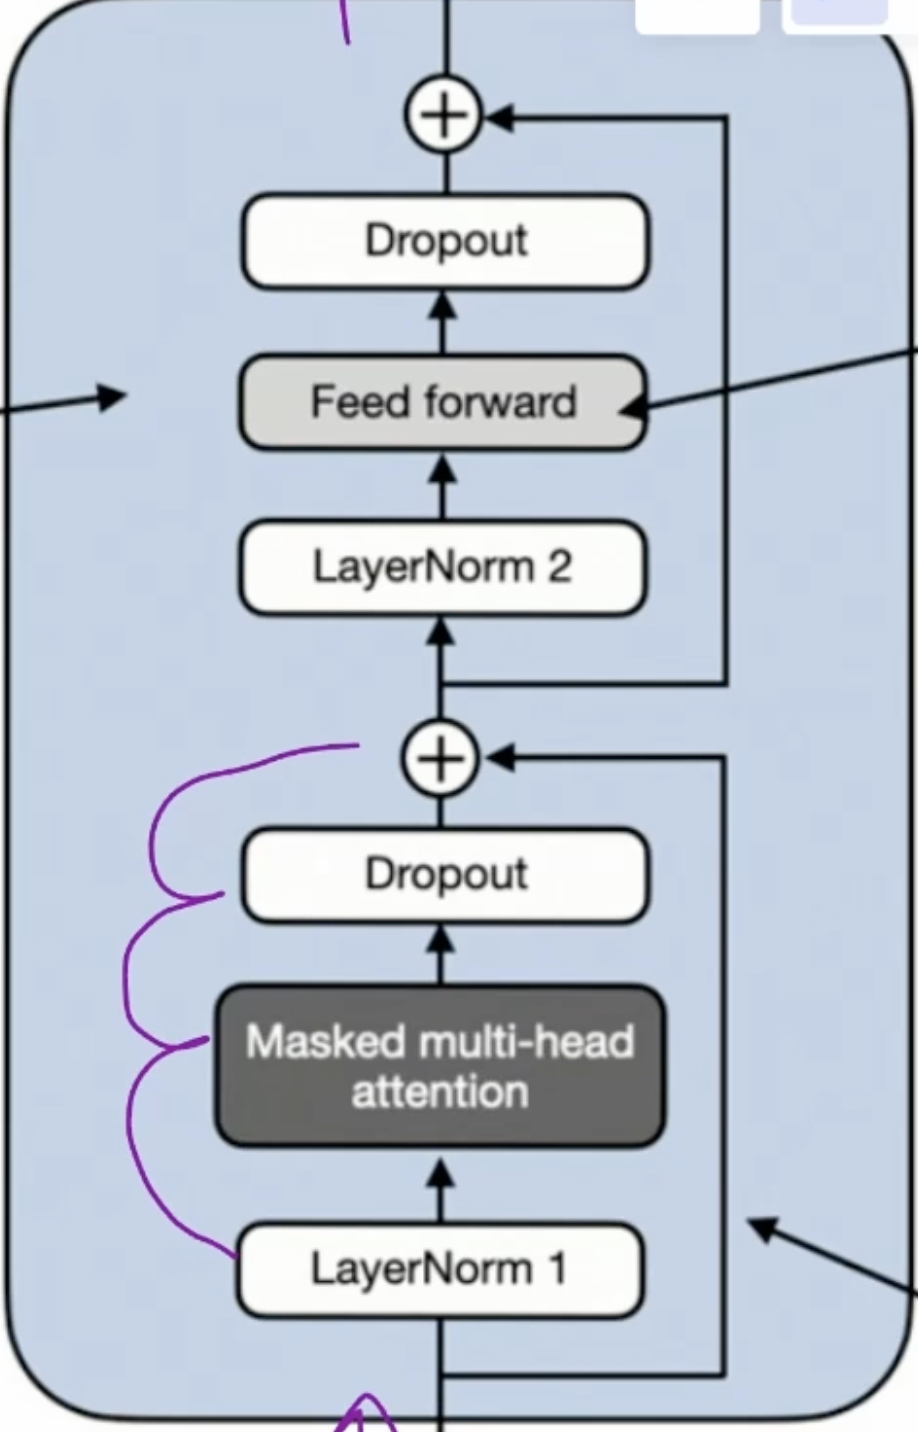

In [ ]:
# Multi Head Attention Class
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length,
               num_heads, dropout=0.0, qkv_bias=False):
    super().__init__()
    assert (d_out % num_heads == 0), \
      "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
      "mask",torch.triu(torch.ones(context_length, context_length),diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape

    queries = self.W_query(x) # Shape: (b, num_tokens, d_out)
    keys = self.W_key(x)
    values = self.W_value(x)

    # Implicitly split the matrix by adding a `num_heads` dimension
    # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)

    # Group matrices by number of head
    # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
    queries = queries.transpose(1, 2)
    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)

    # Find attention score
    attn_scores = queries @ keys.transpose(2, 3) # Dot product of each head

    # Mask attention score, TRIU
    # Original mask truncated to the number of tokens and converted to boolean
    mask_boll = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores = attn_scores.masked_fill(mask_boll, -torch.inf)

    # Find Attnetion Weight
    attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim=-1)
    # Dropout
    attn_weights = self.dropout(attn_weights)

    # Calculate context Vector
    context_vector = attn_weights @ values # Shape : (b, num_head, num_tokens, head_dim)
    # Transpose: (b, num_tokens, num_head, head_dim)
    ## Reformate - Group back matrices by number of tokesn now
    context_vector = context_vector.transpose(1, 2)
    # context_vector = (attn_weights @ values).transpose(1, 2) - one liner

    # Combine the results form multiple heads. Combine heads where self.d_out = self.num_heads*self.head_dim
    # Flatten ech token output into one row
    # use of contiguous function is to make sure during reshape matrices are in same block of memory
    context_vector = context_vector.contiguous().view(b, num_tokens, self.d_out)

    # Optional
    context_vector = self.out_proj(context_vector)

    return context_vector

In [ ]:
# GPT config 124M
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary Size
    "context_length": 1024, # Context Length
    "emd_dim": 768,         # Embedding Dimention
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layer
    "drop_rate": 0.1,       # Droput rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
# Code Transformer Block

class TransformerBlock(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.attn = MultiHeadAttention(
        d_in=cfg["emd_dim"],
        d_out=cfg["emd_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emd_dim"])
    self.norm2 = LayerNorm(cfg["emd_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    # Shortcut for attn
    shortcut = x
    x = self.norm1(x) # normalization
    x = self.attn(x) # attnetion, shape [batch_szie, num_token, emb_size]
    x = self.drop_shortcut(x) #drop shortcut
    x = x+shortcut # adding the saved value in result

    # Shortcut for FeedForward
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x+shortcut # adding the saved value in result

    return x



In [ ]:
# Create sample input of shape [batch_size, num_tokens, emb_dim]
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## GPT ARCHITECTURE PART 6: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION

In [ ]:
# GPT Model Class
import torch
import torch.nn as nn

class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emd_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emd_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    # Use a placeholder for TransformerBlock
    self.transformer_block = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
          )
     # Use a placeholder for LayerNorm
    self.layer_norm = LayerNorm(cfg["emd_dim"])

    self.out_head = nn.Linear(cfg["emd_dim"], cfg["vocab_size"],bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.transformer_block(x)
    x = self.layer_norm(x)
    logits = self.out_head(x)
    return logits



In [ ]:
# Run with Dummy input
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch: \n", batch)
print("\nOutput shape \n", out.shape)
print("\nOutput: \n", out)

Input batch: 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape 
 torch.Size([2, 4, 50257])

Output: 
 tensor([[[-0.0939, -0.2257,  0.3101,  ..., -0.4865,  0.7681,  0.3117],
         [-0.6697, -0.2337,  0.0400,  ..., -0.0158, -0.0865,  1.7397],
         [-1.3821, -0.7332, -0.3937,  ...,  0.3729,  0.1190,  0.1642],
         [-0.1512,  0.2546,  0.3693,  ...,  0.8196,  0.6984, -0.4719]],

        [[-0.2477,  0.1082, -0.6077,  ...,  0.0646,  0.7117,  0.4195],
         [ 0.7072,  0.4718,  0.0270,  ...,  0.5623,  0.8918,  0.2949],
         [-0.5097, -0.1973, -0.7551,  ...,  0.4399, -0.0444, -0.0623],
         [-0.2141, -0.6951,  0.0989,  ...,  0.7375,  0.6525, -0.5369]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
# Print parameters (163 M in output)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total numbe rof parameters: {total_params:,}")


Total numbe rof parameters: 163,009,536


In [ ]:
# Why 163M as GPT model we are following actually has 124M?
# Reason is weight tying
# Let's understand

print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape torch.Size([50257, 768])


In [ ]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [ ]:
# Print space take by model
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## GPT ARCHITECTURE PART 7: GENERATING TEXT FROM OUTPUT TOKENS

There is no training done yet it just we have the GPT model and we will try to predict for fun 😃
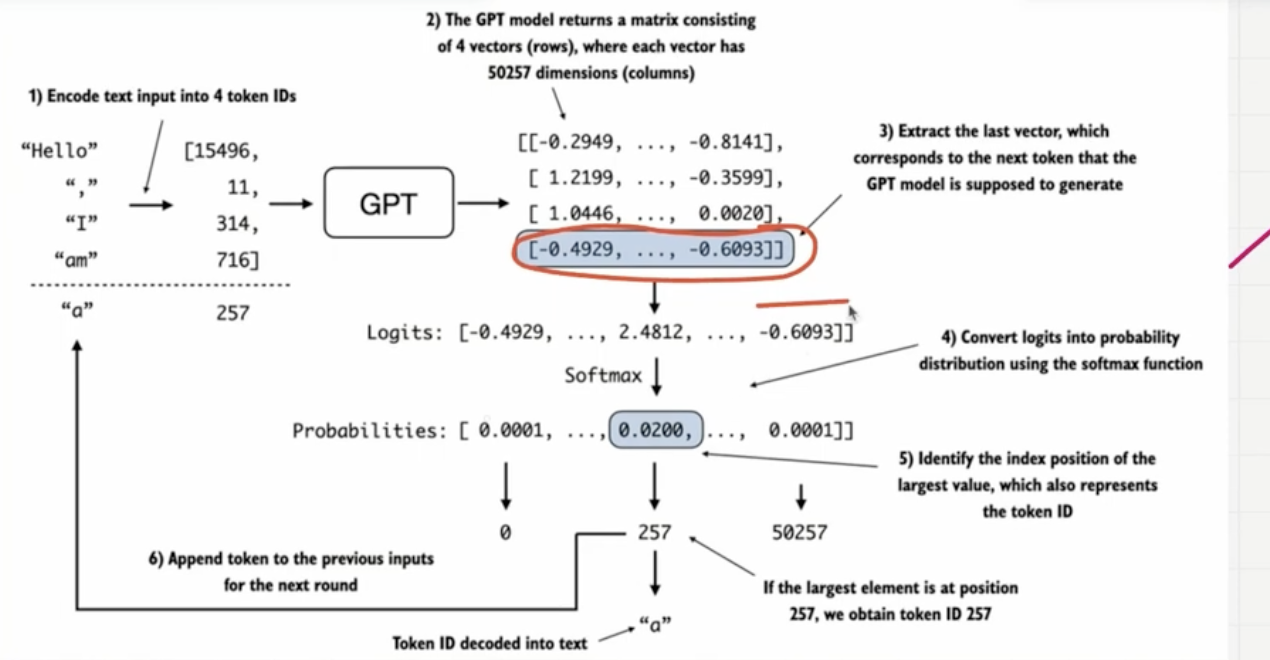

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  # idx is (batch, n_tokens) array of indices in the current context
  for _ in range(max_new_tokens):
    # Crop current context if it exceeds the supported context size
    # E.g., if LLM supports only 5 tokens, and the context size is 10
    # then only the last 5 tokens are used as context
    idx_cond = idx[:, -context_size:]
    # Get the predictions
    with torch.no_grad():
      logits = model(idx_cond) # Shape (batch, n_tokens, vocab_size)

    # Focus only on the last time step
    # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
    logits = logits[:, -1, :]
    # Apply softmax to get probabilities
    probs = torch.softmax(logits, dim=-1) # (batch, vocab_size)
    # Get the idx of the vocab entry with the highest probability value
    idx_next = torch.argmax(probs, dim=-1, keepdim=True) # (batch, 1)
    # Append sampled index to the running sequence
    idx = torch.cat((idx, idx_next), dim=1) # (batch, n_tokens+1)

  return idx



In [ ]:
# input and model
# import tiktoken
# tokenizer = tiktoken.get_encoding("gpt2")
# batch = []
# txt1 = "Every effort moves you"
# txt2 = "Every day holds a"
# batch.append(torch.tensor(tokenizer.encode(txt1)))
# batch.append(torch.tensor(tokenizer.encode(txt2)))
# batch = torch.stack(batch, dim=0)

start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

model_2 = GPTModel(GPT_CONFIG_124M)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model_2.eval()
out = generate_text_simple(
    model=model_2,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
  )
print("Output: \n", out)
print("Output.length: \n", len(out[0]))

Output: 
 tensor([[15496,    11,   314,   716, 19703, 22748, 18175, 16160, 23977,  8198]])
Output.length: 
 10


In [ ]:
decoded_text = tokenizer.decode(out[0].tolist())
print(decoded_text)

Hello, I amProtowntown suppress Stay masc scores
